# Práctica 1: Reconocimiento de dígitos manuscritos con extracción manual de características

El nuevo banco "First bank of Wiki" desea implementar un sistema de reconocimiento automático de cheques como el siguiente:

![texto alternativo](https://upload.wikimedia.org/wikipedia/commons/b/b9/CanadianChequeSample.png)


Actualmente, el banco cuenta con un sistema capaz de aislar los dígitos y convertirlos en imágenes de 8 x 8, pero no de reconocer de qué dígito se trata. Por esa razón, nos ha solicitado realizar un módulo capaz de reconocer dígitos manuscritos dada una imagen de 8 x 8 pixeles:


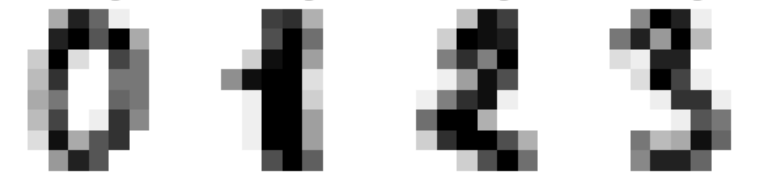



# Cargando los datos

Primero vamos a cargar el dataset y visualizar algunos dígitos.

In [74]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Perceptron
import pandas as pd

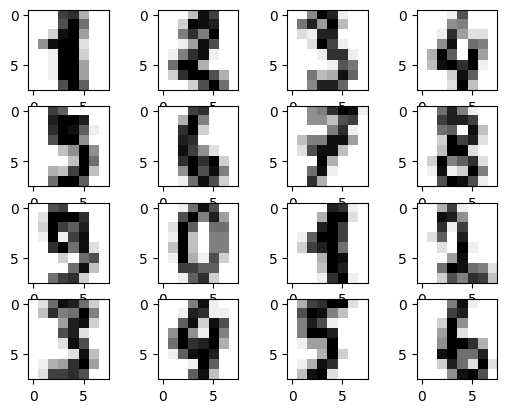

In [1]:
digits = load_digits()

for i in range(1, 4*4+1):
    plt.subplot(4,4,i)
    plt.imshow(digits.images[i,:,:], cmap=plt.get_cmap('gray_r'))

# Binarizando el problema

Para comenzar con un problema más simple, sólo trabajaremos en el escenario de clasificación binaria para dígitos 0 y 1. Para eso, primero filtramos los datos y luego los particionamos en training y test folds.

In [2]:
# Cargo los dígitos
# X, y = load_digits(return_X_y=True)
X, y = digits.images, digits.target

# Filtro los que sean 0 o 1
indices = np.array(range(X.shape[0]))
bin_indices = indices[(y==0) | (y == 1)]

X_bin = X[bin_indices,:,:]
y_bin = y[bin_indices]

# Creo los splits para training y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_bin_train, X_bin_test, y_bin_train, y_bin_test = train_test_split(X_bin, y_bin, test_size=0.33, random_state=42)

print("Total de datos para clasificación entre 10 dígitos: " + str(y.shape[0]))
print("Total de datos para clasificación binaria: " + str(y_bin.shape[0]))
print("Total de 1s para clasificación binaria: " + str(y_bin_test.sum()))
print("Total de 0s para clasificación binaria: " + str(y_bin_test.shape[0] - y_bin_test.sum()))


Total de datos para clasificación entre 10 dígitos: 1797
Total de datos para clasificación binaria: 360
Total de 1s para clasificación binaria: 60
Total de 0s para clasificación binaria: 59


Visualizamos ahora los dígitos del problema binario

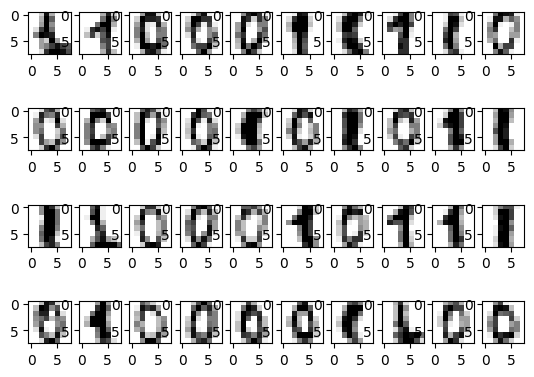

In [3]:
for i in range(1,4*10+1):
    plt.subplot(4,10,i)
    plt.imshow(X_bin_train[i,:,:], cmap=plt.get_cmap('gray_r'))

# Entrenando un perceptrón simple con extracción manual de características para clasificación binaria

Ahora procederemos a entrenar un perceptrón usando la biblioteca Scikit Learn. Esta biblioteca de aprendizaje automático implementa muchísimos modelos listos para usar. En este caso, usaremos el perceptrón simple `sklearn.linear_model.Perceptron`

Pero antes de definir el perceptrón, vamos a definir el método de extracción de características que transformará una imagen (`np.array`) de 8 x 8 en un vector unidimensional de 2 componentes. Para ello, podemos probar con dos estrategias diferentes (si se les ocurre alguna otra, adelante!):

* **Estrategia 1:** vamos a considerar la feature 0 como la media de intensidades de la parte superior del dígito (filas 0 a 3) y y la feature 1 como la media de la parte inferior (filas 4 a 7) tal como indica la imagen:

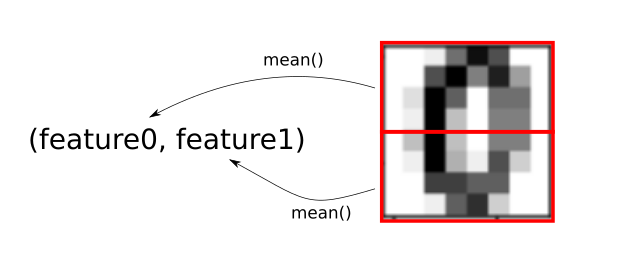

* **Estrategia 2:** Como alternativa, vamos a considerar la feature 0 como la media de toda la imagen, y la feature 1 como el desvío estandar:

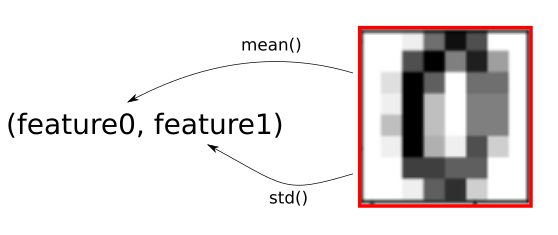


In [68]:
def extract_features_mean_std(x):
    x_out = np.zeros(shape=(1,2))
    x_out[0,0] = np.mean(x)
    x_out[0,1] = np.std(x)
    
    return x_out

def extract_features_mean_top_bottom(x):
    x_out = np.zeros(shape=(1,2))
    x_out[0,0] = np.mean(x[:4,:])
    x_out[0,1] = np.mean(x[4:,:])

    return x_out

def extract_features_mean_left_right(x):
    x_out = np.zeros(shape=(1,2))
    x_out[0,0] = np.mean(x[:,:4])
    x_out[0,1] = np.mean(x[:,4:])

    return x_out

def extract_features_mean_diag1(x):
    x_out = np.zeros(shape=(1,2))
    x_out[0,0] = np.mean([x[i, j] for i in range(8) for j in range(i, 8)])
    x_out[0,1] = np.mean([x[i, j] for i in range(8) for j in range(8) if i > j])
    
    return x_out

def extract_features_mean_diag2(x):
    x_out = np.zeros(shape=(1,2))
    x_out[0,0] = np.mean([x[i,j] for i in range(8) for j in range(8-i)])
    x_out[0,1] = np.mean([x[i,j] for i in range(8) for j in range(8) if i > j])
    
    return x_out


def preprocess_features(X, feature_extractor):
    X_pp = np.zeros(shape=(X.shape[0], 2))

    for i in range(X.shape[0]):
        X_pp[i,:] = feature_extractor(X[i,:,:])

    return X_pp

Ahora implementamos el perceptrón usando la clase `sklearn.linear_model.Perceptron` y lo entrenamos usando las features elegidas (probar con ambas features y ver cuál da mejor accuracy).

In [69]:
def preprocess(option: str, X : np.ndarray) -> np.ndarray:
  if option == 'mean-std':
    return preprocess_features(X, extract_features_mean_std)
  elif option == 'mean-top-bottom':
    return preprocess_features(X, extract_features_mean_top_bottom)
  elif option == 'mean-left-right':
    return preprocess_features(X, extract_features_mean_left_right)
  elif option == 'mean-diag1':
    return preprocess_features(X, extract_features_mean_diag1)
  elif option == 'mean-diag2':
    return preprocess_features(X, extract_features_mean_diag2)
  else:
    raise ValueError("Option must be mean-std or mean-top-bottom")

# Visualizando las features

Para entender el grado de discriminabilidad que presentan nuestras features, vamos a visualizarlas. Para hacerlo, colorear los items de cada clase con un color diferente.

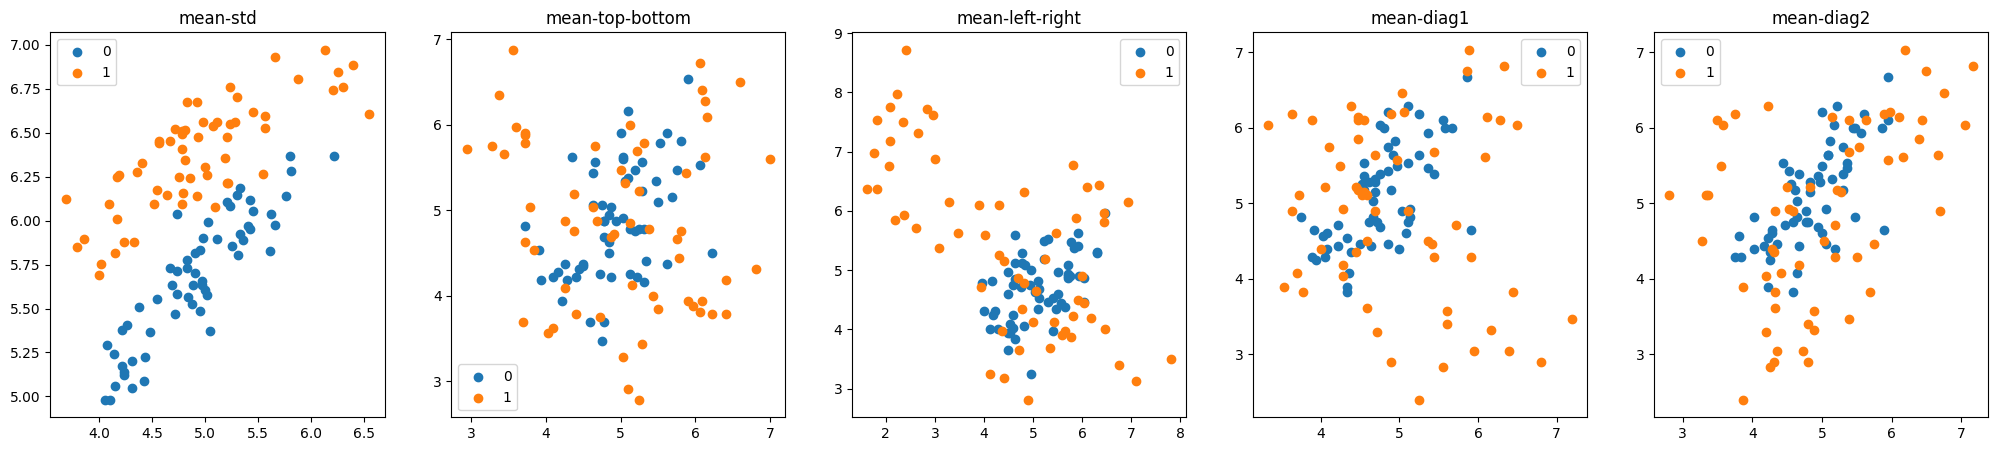

In [79]:
# Definimos un pereceptrón
clasificador = Perceptron()
accuracyDF = pd.DataFrame()
estrategias = ['mean-std', 'mean-top-bottom', 'mean-left-right','mean-diag1', 'mean-diag2']

fig, axs = plt.subplots(1, len(estrategias), figsize=(len(estrategias)*5, 5))
for i, estrategia in enumerate(estrategias):
    # Transformamos las features de los datos para el problema binario
    X_bin_train_features = preprocess(estrategia, X_bin_train)
    X_bin_test_features = preprocess(estrategia, X_bin_test)

    # Entrenamos el clasificador
    clasificador.fit(X_bin_train_features, y_bin_train)
    accuracy = clasificador.score(X_bin_test_features, y_bin_test)
    accuracyDF = pd.concat([accuracyDF, pd.DataFrame({'Estrategia': [estrategia], 'Accuracy': [accuracy]})])

    # scatter plot
    for digit in [0, 1]:
        axs[i].scatter(X_bin_test_features[y_bin_test == digit, 0], X_bin_test_features[y_bin_test == digit, 1], label=str(digit))
    axs[i].set_title(estrategia)
    axs[i].legend()


In [80]:
accuracyDF.sort_values(by='Accuracy', ascending=False)
accuracyDF

,Estrategia,Accuracy
0,mean-std,0.831933
0,mean-top-bottom,0.537815
0,mean-left-right,0.563025
0,mean-diag1,0.596639
0,mean-diag2,0.436975


# Complicando las cosas: 


Ahora volvemos al caso de 10 dígitos y probamos la misma estrategia que estábamos usando anteriormente.

Para intentar entender por qué disminuye tan drásticamente la performance, visualicen las features de las 10 clases coloreando cada punto en un color diferente como hicimos anteriormente.

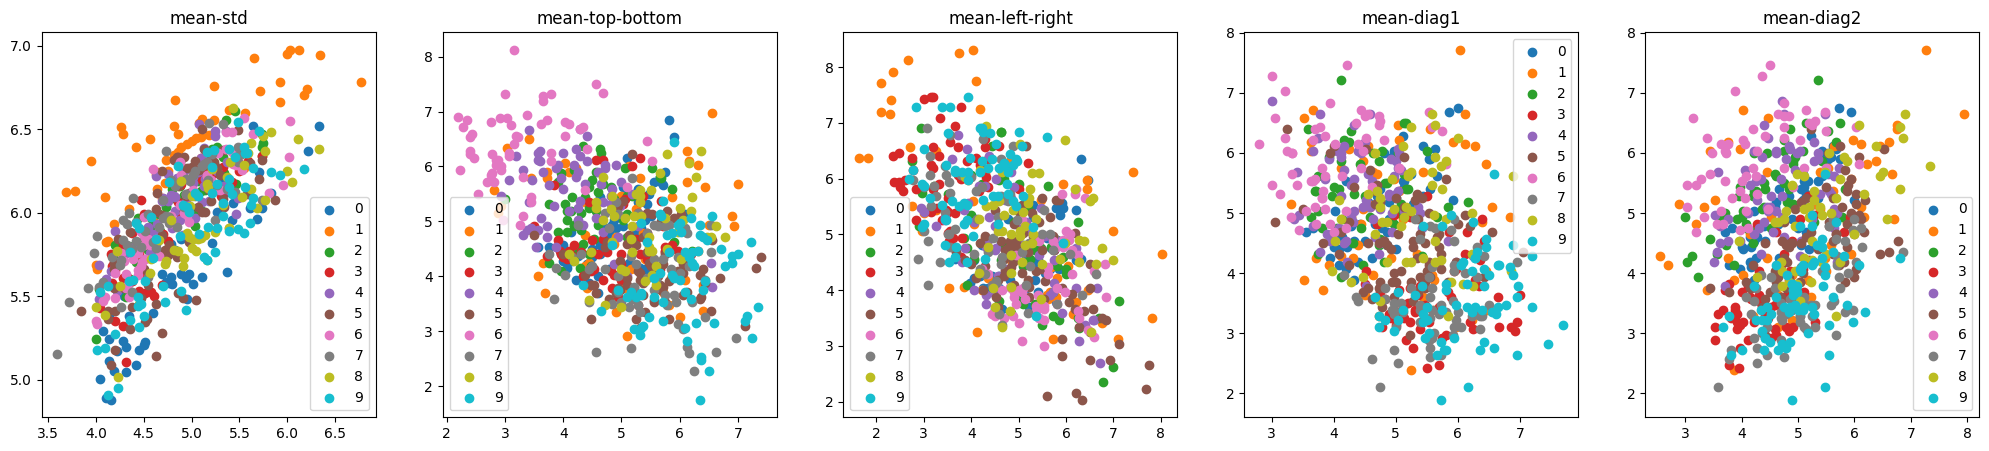

In [86]:
# Definimos un pereceptrón
clasificador10 = Perceptron()
accuracyDF = pd.DataFrame()
estrategias = ['mean-std', 'mean-top-bottom', 'mean-left-right','mean-diag1', 'mean-diag2']

fig, axs = plt.subplots(1, len(estrategias), figsize=(len(estrategias)*5, 5))
for i, estrategia in enumerate(estrategias):
    # Transformamos las features de los datos para el problema binario
    X_train_features = preprocess(estrategia, X_train)
    X_test_features = preprocess(estrategia, X_test)

    # Entrenamos el clasificador
    clasificador10.fit(X_train_features, y_train)
    accuracy = clasificador10.score(X_test_features, y_test)
    accuracyDF = pd.concat([accuracyDF, pd.DataFrame({'Estrategia': [estrategia], 'Accuracy': [accuracy]})])

    # scatter plot
    for digit in range(10):
        axs[i].scatter(X_test_features[y_test == digit, 0], X_test_features[y_test == digit, 1], label=str(digit))
    axs[i].set_title(estrategia)
    axs[i].legend()


In [87]:
accuracyDF.sort_values(by='Accuracy', ascending=False)
accuracyDF

,Estrategia,Accuracy
0,mean-std,0.139731
0,mean-top-bottom,0.166667
0,mean-left-right,0.146465
0,mean-diag1,0.168350
0,mean-diag2,0.107744


# Entregable:
* Deberán entregar el Colab completo con el código funcionando. Además, deberán incluir (en el mismo Colab) un pequeño informe donde muestren las visualizaciones de las features, y responder a las siguientes preguntas:

1. ¿Cuál fue la estrategia de extracción de características que mejor te funcionó? Visualizar las features generadas por los extractores implementados y utilizarlas para explicar por qué funcionó mejor esa estrategia.

2. ¿Cuál sería la accuracy para un algoritmo que prediga aleatoriamente las clases en el caso del problema binario si los datos de test estuvieran balanceados? ¿Y en el caso del problema multiclase de 10 dígitos? 

3. El clasificador diseñado en cada caso (binario y multiclase), ¿Funcionó mejor que un clasificador aleatorio?



# Respuesta:
1. Además de las dos estrategias propuestas en el enunciado, probamos con otras tres estrategias: 
- `mean-left-right` : calcula la media de los valores de los píxeles de la parte izquierda y derecha de la imagen.
- `mean-diag1`: calcula la media de los valores de los píxeles de la diagonal superior izquierda y la diagonal inferior derecha.
- `mean-diag2`: calcula la media de los valores de los píxeles de la diagonal superior derecha y la diagonal inferior izquierda.
La estrategia que mejor funcionó fue "mean-std", con un accuracy de 0.83 para el experimento binario, separando muy bien las clases. Creemos que esto ocurre ya que la media provee información de la intensidad de la imagen. Podríamos pensar que cuanto menos píxeles en negro tenga una imagen, menor será este valor. Al mismo tiempo, la desviación estándar provee información de la dispersión de los píxeles en negro. Dos fuentes de información muy ricas para distinguir el 0 del 1. Las otras estrategias no lograron separar las clases de manera tan clara como "mean-std".

Para el experimento que incluye todos los dígitos del 0 al 9, vemos que no basta diseñar un modelo con un perceptrón lineal. No solo existe una gran variedad de formas en las cuales se puede escribir un solo dígito, sino que también existen varias sutilezas que no pueden ser diferenciadas por ninguna estrategia que esté conformada por dos características.

2. La definición de accuracy en el caso binario es $$\text{Accuracy} = \frac{TP+TN}{TP+TN+FP+FN}$$ En caso de que el algortimo prediga aleatoriamente las clases con $N$ datos de test balanceados, esperariamos tener $TP=TN=FP=FN=\frac{1}{4}N$. Por lo que tendríamos $$\text{Accuracy} = \frac{\frac{1}{4}N+\frac{1}{4}N}{\frac{1}{4}N+\frac{1}{4}N+\frac{1}{4}N+\frac{1}{4}N}=\frac{N/2}{N}=\frac{1}{2}$$

Para el caso de 10 clases, el accuracy es simplemente la fracción de clasificaciones correctas: $$\text{Accuracy} = \frac{\text{Clasificaciones correctas}}{\text{Clasificaciones incorrectas}}$$
accuracy_score (sklearn): "In multilabel classification, this function computes subset accuracy: the set of labels predicted for a sample must *exactly* match the corresponding set of labels in y_true." Si la probabilidad de que una muestra esté correctamente clasificada es 1/10, entonces en promedio, el accuracy esperado sería 0.1.

3. En el caso binario, el clasificador diseñado funcionó mejor que un clasificador aleatorio. En el caso de los 10 dígitos, el clasificador no funcionó mejor que un clasificador aleatorio. Con esto nos referimos a que no subió ni siquiera un punto porcentual por encima de la probabilidad de clasificación aleatoria. 